** Building an LSTM Model for the pre processed Dataset**

In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
df = pd.read_csv('preprocessed_dataset.csv')
df.head()

,title,real,cleaned_title,stemmed_title,lemmatized_title
0,Kandi Burruss Explodes Over Rape Accusation on...,1,kandi burruss explodes rape accusation real ho...,kandi burruss explod rape accus real housew at...,kandi burruss explodes rape accusation real ho...
1,People's Choice Awards 2018: The best red carp...,1,peoples choice awards best red carpet looks,peopl choic award best red carpet look,people choice award best red carpet look
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1,sophia bush sends sweet birthday message one t...,sophia bush send sweet birthday messag one tre...,sophia bush sends sweet birthday message one t...
3,Colombian singer Maluma sparks rumours of inap...,1,colombian singer maluma sparks rumours inappro...,colombian singer maluma spark rumour inappropr...,colombian singer maluma spark rumour inappropr...
4,Gossip Girl 10 Years Later: How Upper East Sid...,1,gossip girl years later upper east siders shoc...,gossip girl year later upper east sider shock ...,gossip girl year later upper east siders shock...


In [ ]:
# Load the preprocessed dataset
data_set = df

def preprocess_data(df, text_column, target_column):
    # Ensure the target variable is binary
    assert df[target_column].nunique() == 2, "Target variable must be binary."

    # Select the text column and the target variable
    texts = df[text_column].astype(str)
    labels = df[target_column]

    return texts, labels

In [ ]:
def tokenize_and_pad(texts, max_words=15000, max_sequence_length=100):
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)

    X_sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to ensure uniform input length
    X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

    return X_padded, tokenizer

In [ ]:
def split_data(X, y, test_size=0.3, random_state=42):
    # Split the dataset into training and testing sets
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def build_model(max_words, max_sequence_length):
    # Build the LSTM model
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
     # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def train_model(model, X_train, Y_train, epochs=5, batch_size=64, validation_split=0.3):
    # Train the model with a validation split
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return history

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          1920000   
                                                                 
 lstm_8 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2101057 (8.01 MB)
Trainable params: 2101

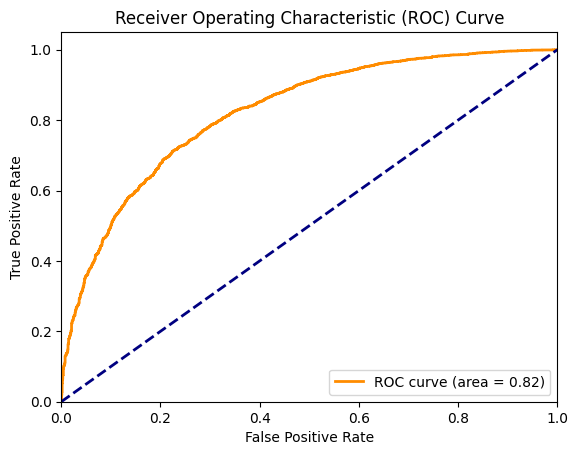

In [ ]:
def main():

    text_column = 'cleaned_title'
    target_column = 'real'
    texts, labels = preprocess_data(df, text_column, target_column)

    # Tokenize and pad the texts
    max_words = 15000
    max_sequence_length = 100
    X_padded, tokenizer = tokenize_and_pad(texts, max_words, max_sequence_length)

    # Split the data
    X_train, X_test, Y_train, Y_test = split_data(X_padded, labels)

    # Build and train the model
    model = build_model(max_words, max_sequence_length)
    model.summary()

    history = train_model(model, X_train, Y_train)
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test Accuracy: {accuracy}")

    # Plotting the ROC AUC Curve
    y_pred_prob = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()



if __name__ == "__main__":
    main()


The increase in validation loss alongside high training accuracy and decrease in training loss suggests that the model is overfitting to the training data. This is a common issue where the model performs well on training data but poorly on unseen data.
Despite the overfitting, the validation accuracy is still reasonably high, indicating the model has learned relevant features from the data.

To remove this overfitting updated the LSTM model with increasing Epochs with Early Stopping:

Using early stopping can help find the optimal number of epochs and prevent overfitting.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          1920000   
                                                                 
 lstm_12 (LSTM)              (None, 100, 128)          131584    
                                                                 
 dropout_12 (Dropout)        (None, 100, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2101057 (8.01 MB)
Trainable params: 2101

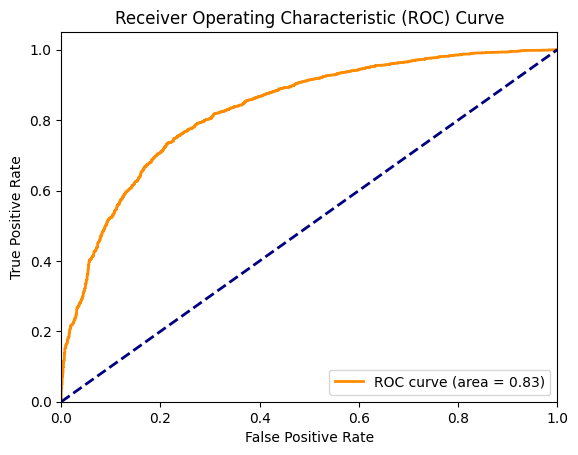

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming data_set is your preprocessed DataFrame
texts = data_set['cleaned_title'].astype(str)
labels = data_set['real']

# Tokenize the text data
max_words = 15000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

X_sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

X_train, X_test, Y_train, Y_test = train_test_split(X_padded, labels, test_size=0.2, random_state=42)

# Build the LSTM model with L2 regularization
model1= Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(64, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history1= model1.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.3, callbacks=[early_stopping])

# Evaluate the model
loss1, accuracy1= model1.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy1}")

# Plotting the ROC AUC Curve
y_pred_prob = model1.predict(X_test).ravel()



In [ ]:
# Evaluate the model
loss1, accuracy1 = model1.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy1}")


145/145 [==============================] - 15s 104ms/step - loss: 0.4488 - accuracy: 0.8108
Test Accuracy: 0.810775876045227


145/145 [==============================] - 13s 87ms/step
Accuracy: 0.8108
Precision: 0.8299
Recall: 0.9430


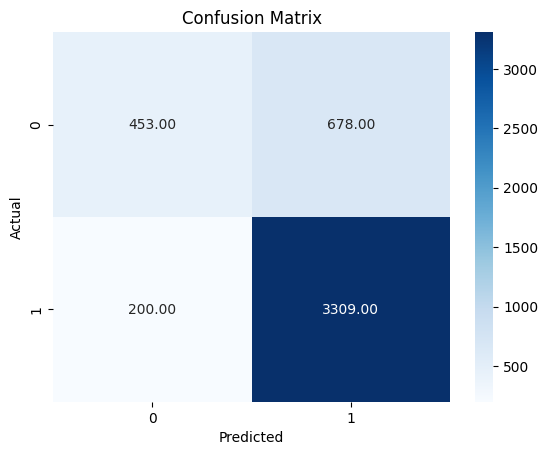

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Predict probabilities and then convert to class labels
Y_pred_prob = model1.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int)  # Assuming a threshold of 0.5 for binary classification

# Calculate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
# Calculate metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Plot confusion matrix as heatmap

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()